In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
currentdir=os.getcwd()
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')

In [3]:
import numpy as np
import pandas as pd
import pinocchio as pin
from pinocchio.rpy import matrixToRpy, rpyToMatrix, rotate
import matplotlib.pyplot as plt
import time
import pickle
import warnings
from dotmap import DotMap
from ipywidgets import interactive, IntSlider, FloatSlider, HBox, VBox, Layout, ToggleButtons, Button
import ipywidgets as widgets

from mocap.viz_visualizer import VisualModel
from mocap.adaptor import MotionAdaptor

warnings.filterwarnings('ignore')
pin.switchToNumpyMatrix()

/Users/dongdong/.local/lib/python3.8/site-packages/robot_properties_solo/config/package_config.ini
model meshes path: ['/Users/dongdong/repos/humanoid_property']
/Users/dongdong/.local/lib/python3.8/site-packages/robot_properties_solo/config/package_config.ini
/Users/dongdong/repos/humanoid_property/urdf/biped_new.urdf
['/Users/dongdong/repos/humanoid_property']


In [4]:
# load humanoid model
m = VisualModel(display=True)

Crocoddyl optimization model with ball: /Users/dongdong/repos/humanoid_property/urdf/humanoid_throw_pinocchio_ball.urdf
Crocoddyl optimization model without ball: /Users/dongdong/repos/humanoid_property/urdf/humanoid_throw_pinocchio_without_ball.urdf
Bullet simulation internal pinocchio model: /Users/dongdong/repos/humanoid_property/urdf/humanoid_throw_pybullet.urdf
Bullet simulation model: /Users/dongdong/repos/humanoid_property/urdf/humanoid_throw_pybullet.urdf
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [5]:
# test quaternion

# pinocchio quaternion order: x, y, z, w
x = [0, 0, 0, 1]
y = [0,0,0]
quat_norm = pin.Quaternion(np.matrix(x).T).normalized()
R = quat_norm.toRotationMatrix()
rpy = matrixToRpy(R)
R_ = rpyToMatrix(np.matrix(y).T)
print(quat_norm, R, rpy, R_)

print(rotate('x', -np.pi / 2))

(x,y,z,w) = 0 0 0 1
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[ 0.]
 [-0.]
 [ 0.]] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 1.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  6.123234e-17  1.000000e+00]
 [ 0.000000e+00 -1.000000e+00  6.123234e-17]]


In [6]:
def read_data(path):
    data = pd.read_csv(path, skiprows = 6)
    df = pd.DataFrame(data)
    #Data processing
    c_quat = [] #chest rotation
    s_quat = [] #shoulder rotation
    u_quat = [] #up arm rotation
    f_quat = [] #front arm rotation
    
    for i in range(0, len(data)) :
        c_quat.append([df.iloc[i][28], df.iloc[i][29], df.iloc[i][30], df.iloc[i][31]])
        s_quat.append([df.iloc[i][119], df.iloc[i][120], df.iloc[i][121], df.iloc[i][122]])
        u_quat.append([df.iloc[i][132], df.iloc[i][133], df.iloc[i][134], df.iloc[i][135]])
        f_quat.append([df.iloc[i][145], df.iloc[i][146], df.iloc[i][147], df.iloc[i][148]])
        
        
    print("data processing done")
    
    return c_quat, s_quat, u_quat, f_quat



def toRot(data):
    ret = []
    for quat in data:
        quat_norm = pin.Quaternion(np.matrix(quat).T).normalized()
        R=quat_norm.toRotationMatrix()
        ret.append(R)
    return ret

def calibrate_data(data, data_reg):
    ret = []
    for d in data:
        R=d.dot(data_reg)
        ret.append(R)
    return ret

def reMapWorldMatList(data):
    ret = []
    m = np.matrix([[1.0, 0.0, 0.0],
                    [0.0, 0.0,  1.0],
                    [0.0, -1.0,  0.0]])
    for d in data:
        R = m.dot(d)
        ret.append(R)
        
    return ret
def reMapWorldMat(data):
    m = np.matrix([[1.0, 0.0, 0.0],
                    [0.0, 0.0,  1.0],
                    [0.0, -1.0,  0.0]])
    R = m.dot(data)
        
    return R

def toRpy(data):
    ret = []
    for d in data:
        ret.append(matrixToRpy(d))
    return ret

def remap(data_child, data_mother):
    ret = []
    for dc, dm in zip(data_child, data_mother):
        R = np.linalg.inv(dm).dot(dc)
        ret.append(R)
    return ret

def plotRpy(rpy, title=""):
    xrange = np.arange(len(rpy))/240.
    plt.plot(xrange,[_rpy[0].item()/np.pi*180 for _rpy in rpy], label='x')
    plt.plot(xrange,[_rpy[1].item()/np.pi*180 for _rpy in rpy], label='y')
    plt.plot(xrange,[_rpy[2].item()/np.pi*180 for _rpy in rpy], label='z')
    plt.legend()
#     plt.ylim([-180, 180])
    plt.xlabel('time [s]')
    plt.ylabel(title+' [degree]')
    
def plotSingleRpy(rpy, i, inverse=False, title=""):
    # i: 0~2, represents the index for plot
    if i>2 or i<0:
        return
    
#     plt.figure(dpi=150)
#     plt.figure()
    xrange = np.arange(len(rpy))/240.
    if inverse:
        plt.plot(xrange,[-1*_rpy[i].item()/np.pi*180 for _rpy in rpy], label=title)
    else:
        plt.plot(xrange,[_rpy[i].item()/np.pi*180 for _rpy in rpy], label=title)
        
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel(title+' [degree]')

def plotSingleRpyVel(rpy, i, inverse=False, title=""):
    # i: 0~2, represents the index for plot
    if i>2 or i<0:
        return
    
#     plt.figure(dpi=150)
    xrange = np.arange(len(rpy))/240.
    if inverse:
        plt.plot(xrange,[-1*_rpy[i].item()/np.pi for _rpy in rpy], label=title)
    else:
        plt.plot(xrange,[_rpy[i].item()/np.pi for _rpy in rpy], label=title)
        
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel(title+' [rad/s]')

In [7]:
calibrate = True

if calibrate:
    #Use shoulder pitch to calibrate the initial posture
    #Remap the data to desired direction coordinate
    
#     path_ = 'calibration/shoulder_pitch/Take 2021-12-16 02.17.24 PM_007.csv'
    path_ = parentdir+'/data/calibration/shoulder_roll/Take 2021-12-16 02.17.24 PM_004.csv'
    c_quat_, s_quat_, u_quat_, f_quat_ = read_data(path_)
    
    c_rot_ = toRot(c_quat_)
    s_rot_ = toRot(s_quat_)
    u_rot_ = toRot(u_quat_)
    f_rot_ = toRot(f_quat_)
    
    c_rot_nw = reMapWorldMatList(c_rot_)
    s_rot_nw = reMapWorldMatList(s_rot_)
    u_rot_nw = reMapWorldMatList(u_rot_)
    f_rot_nw = reMapWorldMatList(f_rot_)

    reg_c_rot_nw = np.linalg.inv(c_rot_nw[0])
    reg_s_rot_nw = np.linalg.inv(s_rot_nw[0])
    reg_u_rot_nw = np.linalg.inv(u_rot_nw[0])
    reg_f_rot_nw = np.linalg.inv(f_rot_nw[0])
    
    pkl = []
    pkl.append(reg_c_rot_nw)
    pkl.append(reg_s_rot_nw)
    pkl.append(reg_u_rot_nw)
    pkl.append(reg_f_rot_nw)
    
    with open(parentdir+'/data/calibration/calibarate_data.pickle', 'wb') as handle:
        pickle.dump(pkl, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(parentdir+'/data/calibration/calibarate_data.pickle', "rb") as handle:
        pkl = pickle.load(handle)
    reg_c_rot_nw = pkl[0]
    reg_s_rot_nw = pkl[1]
    reg_u_rot_nw = pkl[2]
    reg_f_rot_nw = pkl[3]

data processing done


In [8]:
reg_c_rot_nw, reg_s_rot_nw, reg_u_rot_nw, reg_f_rot_nw

(matrix([[-0.94599751, -0.31075069, -0.09231856],
         [ 0.07681815,  0.06178298, -0.99512905],
         [ 0.31494075, -0.94848135, -0.03457525]]),
 matrix([[-0.98762363, -0.14735572,  0.05372012],
         [-0.04938825, -0.03290296, -0.99823754],
         [ 0.14886356, -0.98853613,  0.0252181 ]]),
 matrix([[-0.44366504,  0.07819258, -0.89277503],
         [ 0.87813414, -0.1610449 , -0.45049415],
         [-0.17900217, -0.98384473,  0.00278642]]),
 matrix([[ 0.1243541 ,  0.4629879 , -0.87759801],
         [ 0.90074098, -0.42364536, -0.09586604],
         [-0.41617514, -0.77856715, -0.46971421]]))

In [9]:
#load data from csv

# data
# path =  parentdir+'/data/throw/1/Take 2021-12-16 02.17.24 PM_036.csv'
num = 2

pathlist = [
    "Take 2021-12-16 02.17.24 PM_036",
    "Take 2021-12-16 02.17.24 PM_037",
    "Take 2021-12-16 02.17.24 PM_038",
    "Take 2021-12-16 02.17.24 PM_039",
    "Take 2021-12-16 02.17.24 PM_040",
    "Take 2021-12-16 02.17.24 PM_041",
    "Take 2021-12-16 02.17.24 PM_042",
    "Take 2021-12-16 02.17.24 PM_043",
    "Take 2021-12-16 02.17.24 PM_044",
    "Take 2021-12-16 02.17.24 PM_045"
]
datafolder = parentdir+'/data/throw/'+str(num)+'/'
path =  datafolder+pathlist[num-1]+'.csv'
c_quat, s_quat, u_quat, f_quat = read_data(path)

c_rot = toRot(c_quat)
s_rot = toRot(s_quat)
u_rot = toRot(u_quat)
f_rot = toRot(f_quat)

# map to new world frame
c_rot_nw = reMapWorldMatList(c_rot)
s_rot_nw = reMapWorldMatList(s_rot)
u_rot_nw = reMapWorldMatList(u_rot)
f_rot_nw = reMapWorldMatList(f_rot)

data processing done


In [10]:
#convert data based on calibration data
c_rot_cali = calibrate_data(c_rot_nw, reg_c_rot_nw)
s_rot_cali = calibrate_data(s_rot_nw, reg_s_rot_nw)
u_rot_cali = calibrate_data(u_rot_nw, reg_u_rot_nw)
f_rot_cali = calibrate_data(f_rot_nw, reg_f_rot_nw)

In [11]:
um_rot = remap(u_rot_cali, s_rot_cali)
fm_rot = remap(f_rot_cali, u_rot_cali)

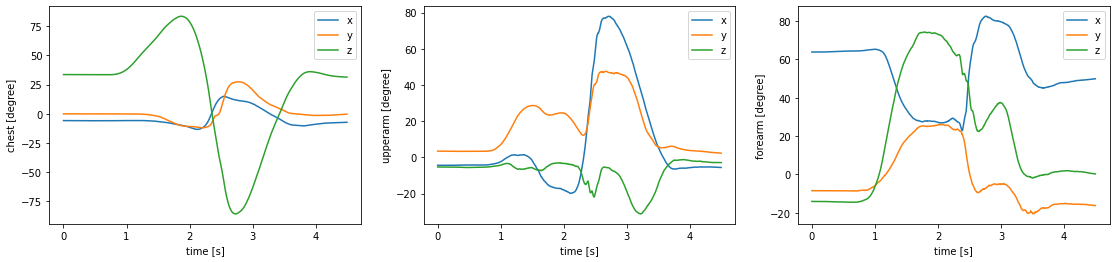

In [12]:
c_rpy = toRpy(c_rot_cali)
u_rpy = toRpy(um_rot)
f_rpy = toRpy(fm_rot)

# y, x, z

# x, y, z
plt.figure(figsize= [19,4])
plt.subplot(1,3,1)
plotRpy(c_rpy, title="chest")
plt.subplot(1,3,2)
plotRpy(u_rpy, title="upperarm")
plt.subplot(1,3,3)
plotRpy(f_rpy, title="forearm")

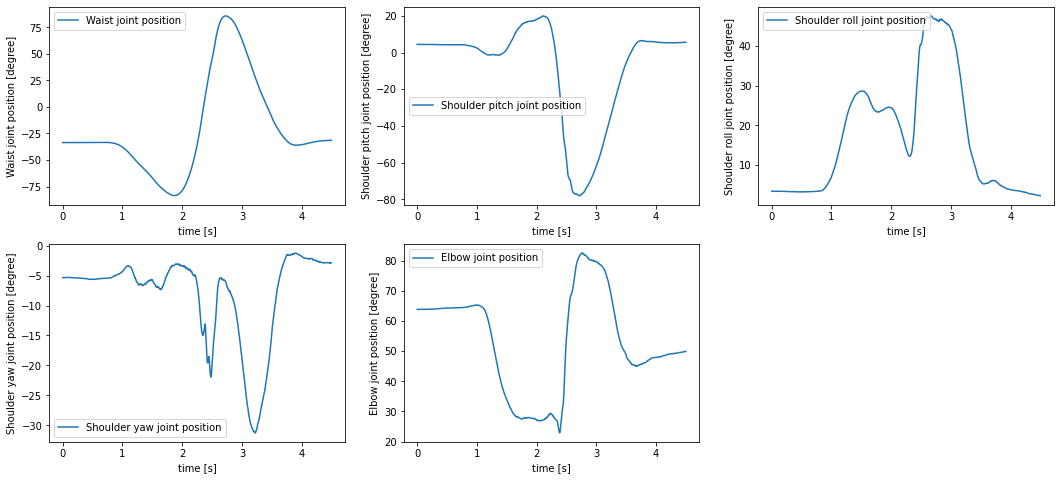

In [13]:
plt.figure(figsize= [18,8])
plt.subplot(2,3,1)
plotSingleRpy(c_rpy, 2, inverse=True, title="Waist joint position")
plt.subplot(2,3,2)
plotSingleRpy(u_rpy, 0, inverse=True, title="Shoulder pitch joint position")
plt.subplot(2,3,3)
plotSingleRpy(u_rpy, 1, title="Shoulder roll joint position")
plt.subplot(2,3,4)
plotSingleRpy(u_rpy, 2, title="Shoulder yaw joint position")
plt.subplot(2,3,5)
plotSingleRpy(f_rpy, 0, title="Elbow joint position")

In [14]:
# convert data to velocity

def toVel(rpy):
    vel = []
    vel.append(np.zeros_like(rpy[0]))
    
    T = len(rpy)
    dt = 1/240.
    for i in range(1, T):
        vel_ = np.zeros_like(rpy[0])
        for j in range(rpy[0].shape[0]):
            
#             print(rpy[i][j,0])
            v = (rpy[i][j,0]-rpy[i-1][j,0])/dt
            vel_[j, 0] = v
        vel.append(vel_)
    return vel


# convert data to acceleration

def toAcc(v_rpy):
    #input is velocity
    
    acc = []
    acc.append(np.zeros_like(v_rpy[0]))
    
    T = len(v_rpy)
    dt = 1/240.
    
    for i in range(1, T):
        acc_ = np.zeros_like(v_rpy[0])
        for j in range(v_rpy[0].shape[0]):
            a = (v_rpy[i][0]-v_rpy[i-1][0])/dt
            acc_[j, 0] = a
        acc.append(acc_)
    return acc

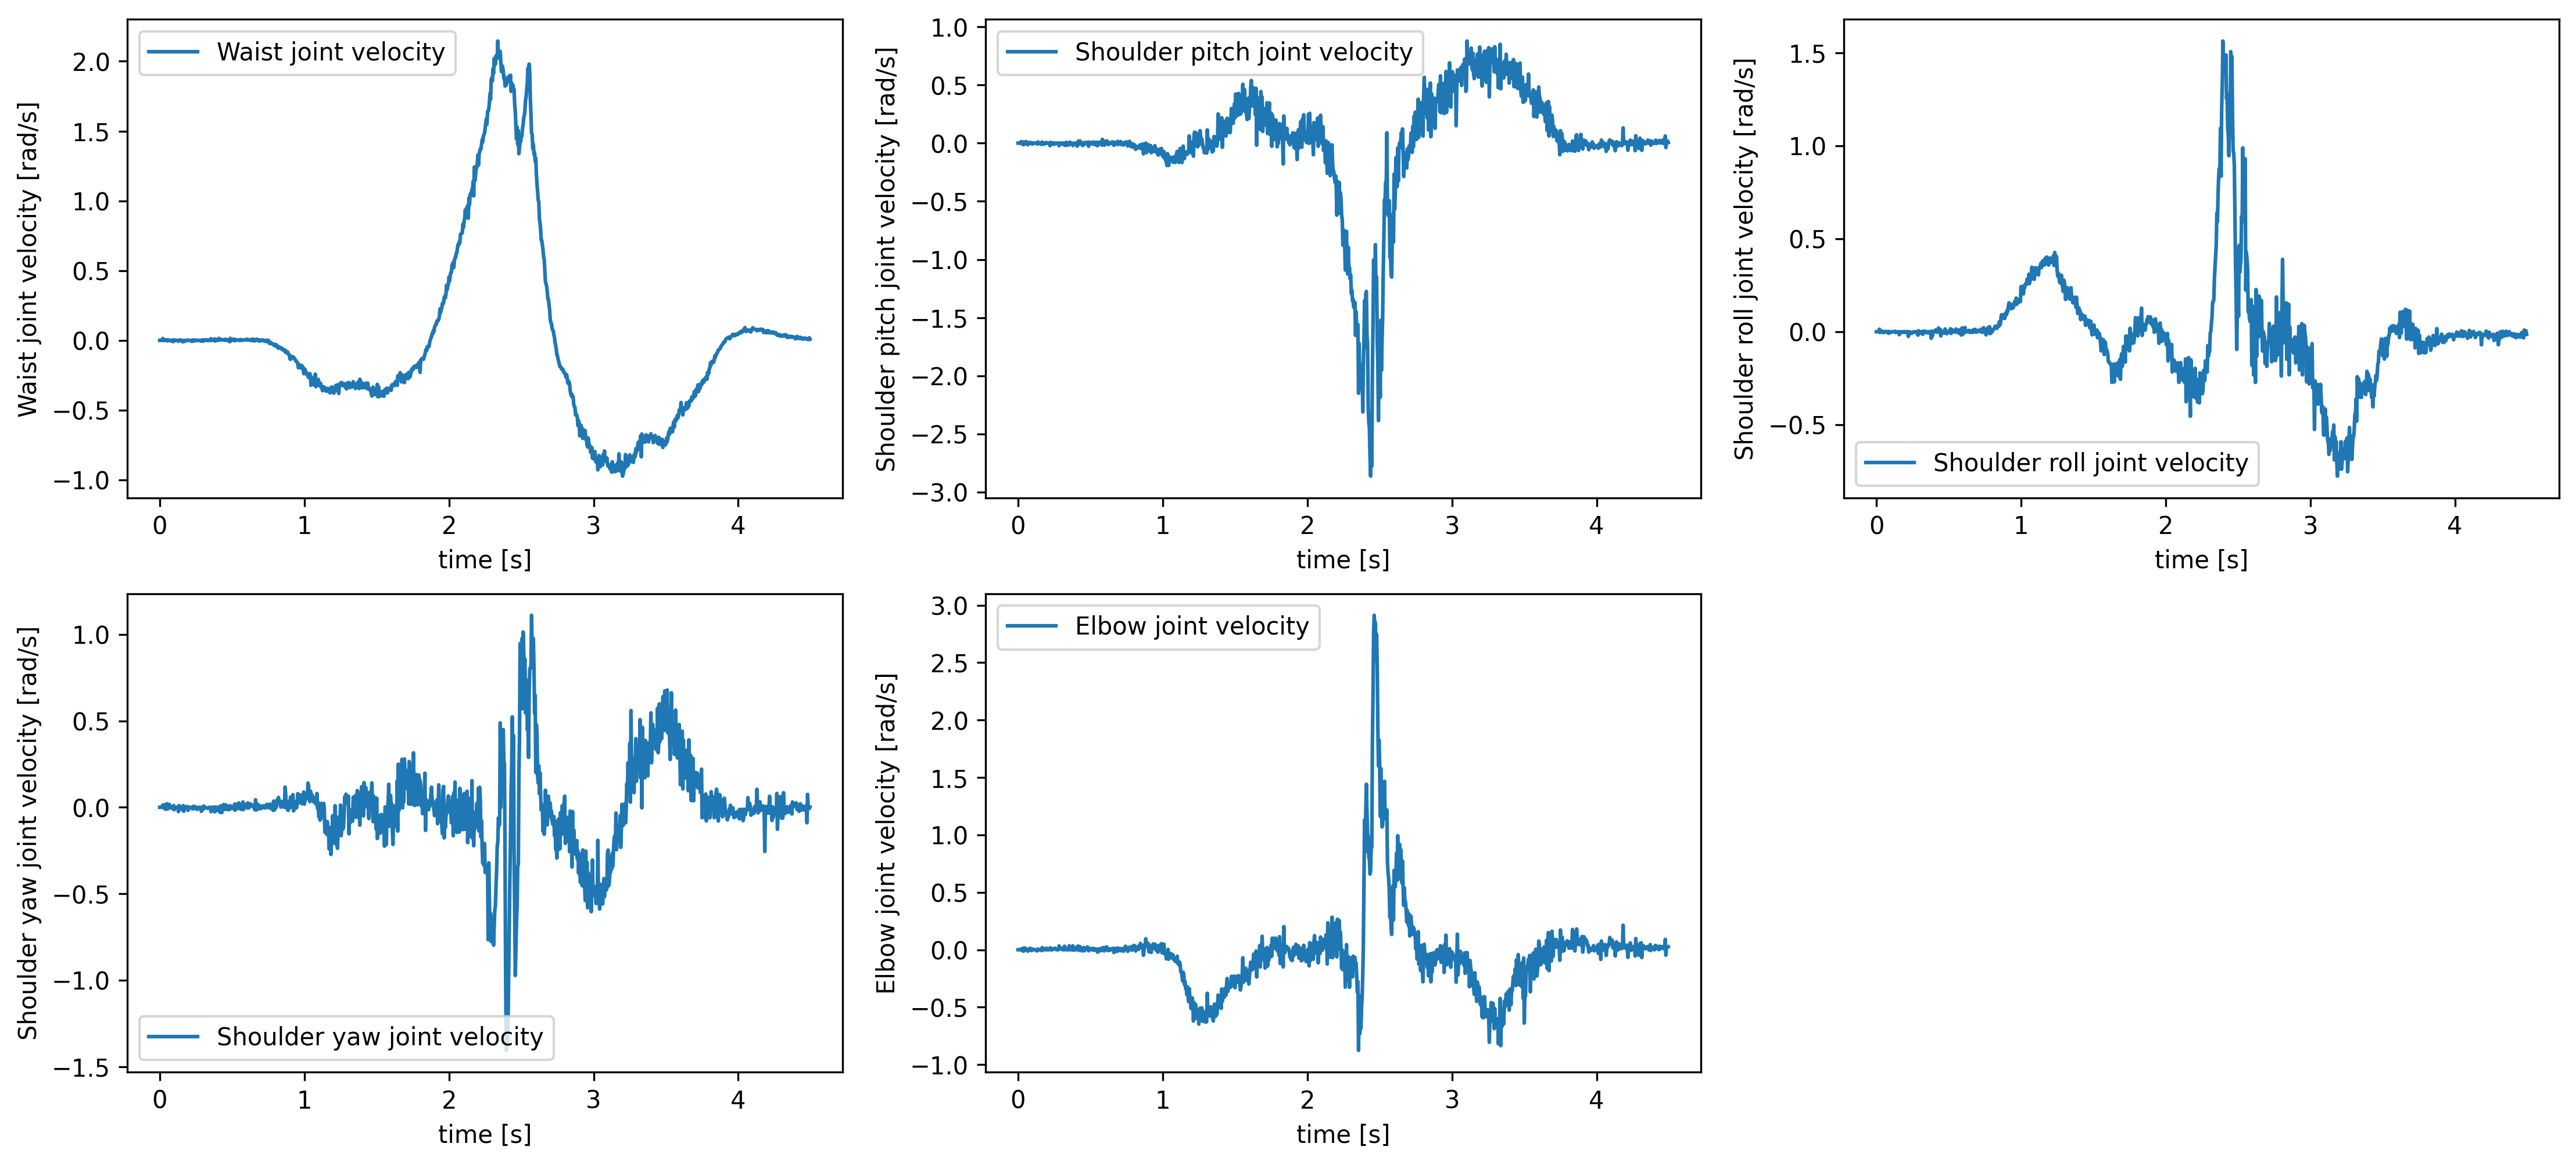

In [15]:
v_c_rpy = toVel(c_rpy)
v_u_rpy = toVel(u_rpy)
v_f_rpy = toVel(f_rpy)
plt.figure(figsize= [18,8],dpi=300)
plt.subplot(2,3,1)
plotSingleRpyVel(v_c_rpy, 2, inverse=True, title="Waist joint velocity")
plt.subplot(2,3,2)
plotSingleRpyVel(v_u_rpy, 0, inverse=True, title="Shoulder pitch joint velocity")
plt.subplot(2,3,3)
plotSingleRpyVel(v_u_rpy, 1, title="Shoulder roll joint velocity")
plt.subplot(2,3,4)
plotSingleRpyVel(v_u_rpy, 2, title="Shoulder yaw joint velocity")
plt.subplot(2,3,5)
plotSingleRpyVel(v_f_rpy, 0, title="Elbow joint velocity")

In [16]:
# # For presentation
# v_c_rpy = toVel(c_rpy)
# v_u_rpy = toVel(u_rpy)
# v_f_rpy = toVel(f_rpy)
# plt.figure(dpi=150)
# plotSingleRpyVel(v_c_rpy, 2, inverse=True, title="Waist joint velocity")
# plt.figure(dpi=150)
# plotSingleRpyVel(v_u_rpy, 0, inverse=True, title="Shoulder pitch joint velocity")
# plt.figure(dpi=150)
# plotSingleRpyVel(v_u_rpy, 1, title="Shoulder roll joint velocity")
# plt.figure(dpi=150)
# plotSingleRpyVel(v_u_rpy, 2, title="Shoulder yaw joint velocity")
# plt.figure(dpi=150)
# plotSingleRpyVel(v_f_rpy, 0, title="Elbow joint velocity")

In [17]:
a_c_rpy = toAcc(v_c_rpy)
a_u_rpy = toAcc(v_u_rpy)
a_f_rpy = toAcc(v_f_rpy)

### QP motion tracking

In [18]:
def adapt(rpy, v_rpy, a_rpy, idx, vel_bound, pos_bound_upper, pos_bound_lower, weightdict):
    
    # rpy position dataset
    # v_rpy velocity dataset
    # a_rpy acceleration dataset
    # i: 0-2,  select index for adapting from input data
    # vel_bound: velocity bound
    # pos_bound: position bound
    # pos
    
    if idx >2 or idx < 0:
        raise Exception('idx argument is incorrect!')
    
    dt = 1/240.
    T = len(rpy)
    nj = 1
    
    q_ref = []
    dq_ref = []
    ddq_ref = []

    for i in range(T):
        q_ = [rpy[i][idx, 0].item()]
        dq_ = [v_rpy[i][idx, 0].item()]
        ddq_ = [a_rpy[i][idx, 0].item()]
        
        q_ref.append(np.array(q_))
        dq_ref.append(np.array(dq_))
        ddq_ref.append(np.array(ddq_))
    
    motorAdaptor = MotionAdaptor(nj, vel_bound, pos_bound_upper, pos_bound_lower, weightdict)
    q = np.zeros(nj)
    dq = np.zeros(nj)
    q = q_ref[0].copy()
    dq = dq_ref[0].copy()
    
    if dq[0]> vel_bound[0].item():
        dq[0] = vel_bound[0].item()
    elif dq[0] <-1*vel_bound[0].item():
        dq[0] = -1*vel_bound[0].item()

    q_new = []
    dq_new = []
    ddq_new = []

    for i in range(T):
        ddq = motorAdaptor.compute(q, dq, q_ref[i], dq_ref[i], ddq_ref[i])
        q_new.append(q.copy())
        dq_new.append(dq.copy())
        ddq_new.append(ddq.copy())
        q, dq = motorAdaptor.forward(q, dq, ddq)
        
    return q_ref, dq_ref, ddq_ref, q_new, dq_new, ddq_new

def plotResult(q_ref, dq_ref, ddq_ref, q_new, dq_new, ddq_new, vel_bound, pos_bound_upper, pos_bound_lower, inverse_ref=False, inverse_new=False):
    
    dt = 1/240.
    
#     fig, ax = plt.subplots(dpi=300)
    fig, ax = plt.subplots()
    if inverse_ref:
        ax.plot(np.arange(len(q_ref))*dt, [-1*q[0]/np.pi*180 for q in q_ref], label='raw data',lw=5, c='g',alpha =.5)
    else:
        ax.plot(np.arange(len(q_ref))*dt, [q[0]/np.pi*180 for q in q_ref], label='raw data',lw=5, c='g',alpha =.5)
        
    if inverse_new:
        ax.plot(np.arange(len(q_ref))*dt, [-1*q[0]/np.pi*180 for q in q_new], label='adapted data',lw=1, c='k')
    else:
        ax.plot(np.arange(len(q_ref))*dt, [q[0]/np.pi*180 for q in q_new], label='adapted data',lw=1, c='k')
        

    plt.axhline(y=pos_bound_upper[0].item()/np.pi*180., color='r', linestyle=':', lw = 3,alpha=.3)
    plt.axhline(y=pos_bound_lower[0].item()/np.pi*180., color='r', linestyle=':', lw = 3,alpha=.3)
    ax.legend()
    plt.ylabel('Joint position [degree]')
    plt.xlabel('time [s]')
    plt.show()

#     fig, ax = plt.subplots(dpi=300)
    fig, ax = plt.subplots()
    if inverse_ref:
        ax.plot(np.arange(len(q_ref))*dt, [-1*dq[0] for dq in dq_ref], label='raw data',lw=1., c='g',alpha=0.5)
    else:
        ax.plot(np.arange(len(q_ref))*dt, [dq[0] for dq in dq_ref], label='raw data',lw=1., c='g',alpha=0.5)
    if inverse_new:
        ax.plot(np.arange(len(q_ref))*dt, [-1*dq[0] for dq in dq_new], label='adapted data',lw=.5, c='k')
    else:
        ax.plot(np.arange(len(q_ref))*dt, [dq[0] for dq in dq_new], label='adapted data',lw=.5, c='k')

    plt.axhline(y=vel_bound[0].item(), color='r', linestyle=':', lw = 3,alpha=.3)
    plt.axhline(y=-1*vel_bound[0].item(), color='r', linestyle=':', lw = 3,alpha=.3)
    ax.legend(loc = "upper right")
    plt.ylabel('Joint velocity [rad/s]')
    plt.xlabel('time [s]')
    plt.show()

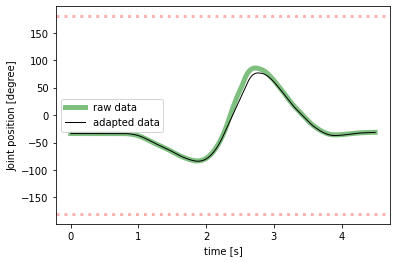

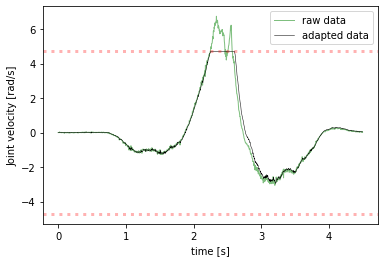

In [19]:
# waist
waist_vel_bound = np.array([4.71]*1)
waist_pos_bound_upper = np.array([180.0/180.*3.14]*1)
waist_pos_bound_lower = np.array([-180.0/180.*3.14]*1)
waist_weightdict = {
              "w_acceleration": 1.,
              "w_tracking": 1.,
              "w_vel": 1.,
              "p_tracking": 600.,
              "d_tracking": 200.,
              }

adapt_waist_q_ref, adapt_waist_v_ref, adapt_waist_a_ref, \
adapt_waist_q, adapt_waist_v, adapt_waist_a = adapt(c_rpy, v_c_rpy, a_c_rpy, 2, \
                                                    waist_vel_bound, waist_pos_bound_upper, waist_pos_bound_lower, waist_weightdict)
plotResult(adapt_waist_q_ref, adapt_waist_v_ref, adapt_waist_a_ref,\
          adapt_waist_q, adapt_waist_v, adapt_waist_a, \
           waist_vel_bound, waist_pos_bound_upper, waist_pos_bound_lower,\
           inverse_ref=True, inverse_new=True)

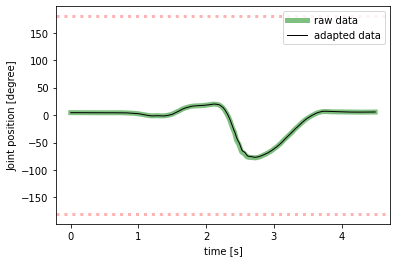

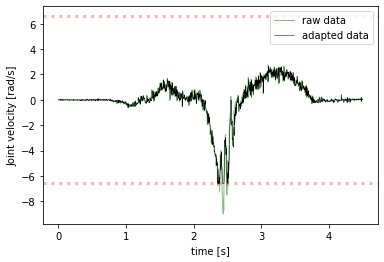

In [20]:
# shoulder_pitch
shoulder_pitch_vel_bound = np.array([6.59]*1)
shoulder_pitch_pos_bound_upper = np.array([180.0/180.*3.14]*1)
shoulder_pitch_pos_bound_lower = np.array([-180.0/180.*3.14]*1)
shoulder_pitch_weightdict = {
              "w_acceleration": 1.,
              "w_tracking": 1.,
              "w_vel": 1.,
              "p_tracking": 600.,
              "d_tracking": 200.,
              }

adapt_shoulder_pitch_q_ref, adapt_shoulder_pitch_v_ref, adapt_shoulder_pitch_a_ref, \
adapt_shoulder_pitch_q, adapt_shoulder_pitch_v, adapt_shoulder_pitch_a = adapt(u_rpy, v_u_rpy, a_u_rpy, 0, \
                                                    shoulder_pitch_vel_bound, shoulder_pitch_pos_bound_upper, shoulder_pitch_pos_bound_lower, shoulder_pitch_weightdict)
plotResult(adapt_shoulder_pitch_q_ref, adapt_shoulder_pitch_v_ref, adapt_shoulder_pitch_a_ref,\
          adapt_shoulder_pitch_q, adapt_shoulder_pitch_v, adapt_shoulder_pitch_a, \
           shoulder_pitch_vel_bound, shoulder_pitch_pos_bound_upper, shoulder_pitch_pos_bound_lower,\
           inverse_ref=True, inverse_new=True)

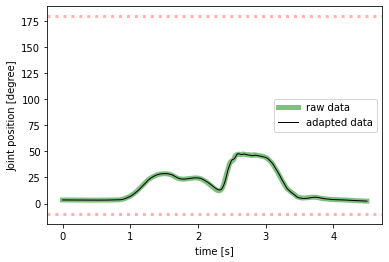

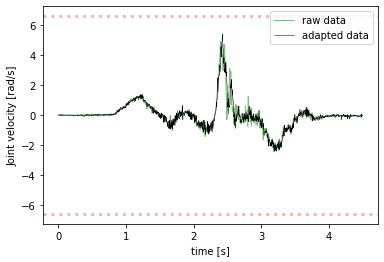

In [21]:
# shoulder_roll
shoulder_roll_vel_bound = np.array([6.59]*1)
shoulder_roll_pos_bound_upper = np.array([180.0/180.*3.14]*1)
shoulder_roll_pos_bound_lower = np.array([-10.0/180.*3.14]*1)
shoulder_roll_weightdict = {
              "w_acceleration": 1.,
              "w_tracking": 1.,
              "w_vel": 1.,
              "p_tracking": 600.,
              "d_tracking": 200.,
              }

adapt_shoulder_roll_q_ref, adapt_shoulder_roll_v_ref, adapt_shoulder_roll_a_ref, \
adapt_shoulder_roll_q, adapt_shoulder_roll_v, adapt_shoulder_roll_a = adapt(u_rpy, v_u_rpy, a_u_rpy, 1, \
                                                    shoulder_roll_vel_bound, shoulder_roll_pos_bound_upper, shoulder_roll_pos_bound_lower, shoulder_roll_weightdict)
plotResult(adapt_shoulder_roll_q_ref, adapt_shoulder_roll_v_ref, adapt_shoulder_roll_a_ref,\
          adapt_shoulder_roll_q, adapt_shoulder_roll_v, adapt_shoulder_roll_a, \
           shoulder_roll_vel_bound, shoulder_roll_pos_bound_upper, shoulder_roll_pos_bound_lower,\
           inverse_ref=False, inverse_new=False)

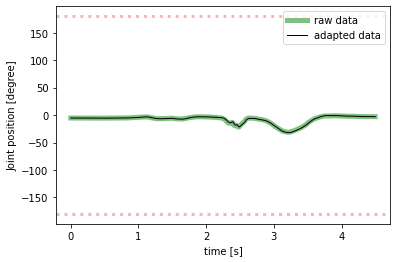

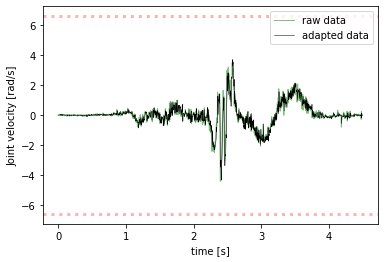

In [22]:
# shoulder_yaw
shoulder_yaw_vel_bound = np.array([6.59]*1)
shoulder_yaw_pos_bound_upper = np.array([180.0/180.*3.14]*1)
shoulder_yaw_pos_bound_lower = np.array([-180.0/180.*3.14]*1)
shoulder_yaw_weightdict = {
              "w_acceleration": 1.,
              "w_tracking": 1.,
              "w_vel": 1.,
              "p_tracking": 600.,
              "d_tracking": 200.,
              }

adapt_shoulder_yaw_q_ref, adapt_shoulder_yaw_v_ref, adapt_shoulder_yaw_a_ref, \
adapt_shoulder_yaw_q, adapt_shoulder_yaw_v, adapt_shoulder_yaw_a = adapt(u_rpy, v_u_rpy, a_u_rpy, 2, \
                                                    shoulder_yaw_vel_bound, shoulder_yaw_pos_bound_upper, shoulder_yaw_pos_bound_lower, shoulder_yaw_weightdict)
plotResult(adapt_shoulder_yaw_q_ref, adapt_shoulder_yaw_v_ref, adapt_shoulder_yaw_a_ref,\
          adapt_shoulder_yaw_q, adapt_shoulder_yaw_v, adapt_shoulder_yaw_a, \
           shoulder_yaw_vel_bound, shoulder_yaw_pos_bound_upper, shoulder_yaw_pos_bound_lower,\
           inverse_ref=False, inverse_new=False)

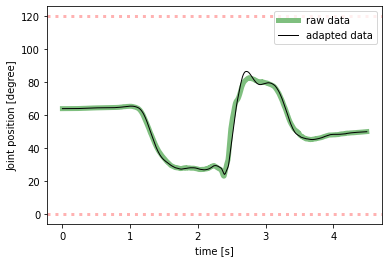

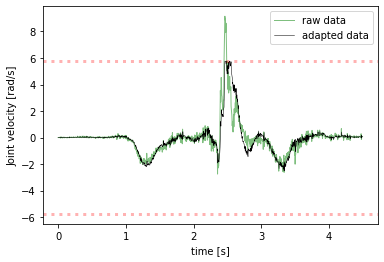

In [23]:
# elbow
elbow_vel_bound = np.array([5.76]*1)
elbow_pos_bound_upper = np.array([120.0/180.*3.14]*1)
elbow_pos_bound_lower = np.array([0.0/180.*3.14]*1)
elbow_weightdict = {
              "w_acceleration": 1.,
              "w_tracking": 1.,
              "w_vel": 1.,
              "p_tracking": 600.,
              "d_tracking": 20.,
              }

adapt_elbow_q_ref, adapt_elbow_v_ref, adapt_elbow_a_ref, \
adapt_elbow_q, adapt_elbow_v, adapt_elbow_a = adapt(f_rpy, v_f_rpy, a_f_rpy, 0, \
                                                    elbow_vel_bound, elbow_pos_bound_upper, elbow_pos_bound_lower, elbow_weightdict)
plotResult(adapt_elbow_q_ref, adapt_elbow_v_ref, adapt_elbow_a_ref,\
          adapt_elbow_q, adapt_elbow_v, adapt_elbow_a, \
           elbow_vel_bound, elbow_pos_bound_upper, elbow_pos_bound_lower,\
           inverse_ref=False, inverse_new=False)

In [24]:
# import numpy as np
# dataset=[13, 22, 26, 38, 36, 42,49, 50, 77, 81, 98, 110]
# print('Mean:', np.mean(dataset))
# print('Standard Deviation:', np.std(dataset))
# Mean:53.5
# Standard Deviation: 29.694275542602483

In [25]:
# display the original trajectory
q = m.q0.copy()
m.viz.display(q)
traj = []
waist_traj = []

for c, u, f in zip(c_rpy, u_rpy, f_rpy):
    traj.append([-u[0].item(),u[1].item(), u[2].item(), f[0].item()])
    waist_traj.append(-1*c[2])

q[24:28] = np.matrix(traj[0]).T
q[19] = waist_traj[0]
m.viz.display(q)

for w, t in zip(waist_traj, traj):
    q[19] = w
    q[24:28] = np.matrix(t).T
    m.viz.display(q)

In [26]:
print(adapt_elbow_q[0].item())

1.114868187474423


In [27]:
# display the new trajectory
q = m.q0.copy()
m.viz.display(q)
traj = []
traj_v = []
waist_traj = []
waist_traj_v = []

for w, wv, sp, spv, sr, srv, sy, syv, e, ev in zip(adapt_waist_q, 
                                                    adapt_waist_v,
                                                    adapt_shoulder_pitch_q, 
                                                    adapt_shoulder_pitch_v,
                                                    adapt_shoulder_roll_q, 
                                                    adapt_shoulder_roll_v,
                                                    adapt_shoulder_yaw_q, 
                                                    adapt_shoulder_yaw_v,
                                                    adapt_elbow_q,
                                                    adapt_elbow_v):
    traj.append([-1*sp.item(),sr.item(), sy.item(), e.item()])
    traj_v.append([-1*spv.item(), srv.item(), syv.item(), ev.item()])
    waist_traj.append(-1*w.item())
    waist_traj_v.append(-1*wv.item())

q[24:28] = np.matrix(traj[0]).T
q[19] = waist_traj[0]
m.viz.display(q)

for w, t in zip(waist_traj, traj):
    q[19] = w
    q[24:28] = np.matrix(t).T
    m.viz.display(q)

In [28]:
def func1(x):
    q = m.q0.copy()
    q[19] = waist_traj[x]
    q[24:28] = np.matrix(traj[x]).T
    m.viz.display(q)
#     time.sleep(.1)
    
w= interactive(func1, x=IntSlider(min=0, max=len(traj)-1, step=1, orientation='horizontal',continuous_update=True, layout=Layout(width='900px')))
display(w)

# initia: 0
# prepare: 529
# throw/release: 739
# recovery: 936
# final:0




interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='900px'), max=1079), Output()), …

In [29]:
data = []

for w, wv, t, tv in zip(waist_traj, waist_traj_v, traj, traj_v):
    dm = DotMap()
    dm.waist = w
    dm.waist = wv
    dm.shoulder_p = t[0]
    dm.shoulder_p_v = tv[0]
    dm.shoulder_r = t[1]
    dm.shoulder_r_v = tv[1]
    dm.shoulder_y = t[2]
    dm.shoulder_y_v = tv[2]
    dm.elbow = t[3]
    dm.elbow_v = tv[3]
    
    data.append(dm)

with open(datafolder+'mocap_data.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [31]:
throw_info = DotMap()
throw_info.start = 196
throw_info.prepare = 443
throw_info.release = 667
throw_info.recovery = 836
throw_info.final = 965
with open(datafolder+'mocap_data_info.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)